# Assignment 4

# Question 1

## Imports

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

## Reading Data

In [2]:
df = pd.read_table('Data/divorce_raw.raw', sep="\s+", header=None)
df.set_axis(['id', 'heduc', 'heblack', 'mixed', 'years', 'div'], axis=1, inplace=True)

### Dataset Description

<b>id</b>: a couple number <br>
<b>heduc</b>: education of the husband - 0 -> less than 12 years, 1 -> 12 to 15 years, 2 -> 16 or more years. <br>
<b>heblack</b>: 1 if the husband is black. <br>
<b>mixed</b>: 1 if husband and wife have different ethnicity, else 0. <br>
<b>years</b>: duration of marriage <br>
<b>div</b>: 1 for divorce; 0 for censoring <br>

For survival analysis, 'heblack' and 'mixed' columns will be dropped. <br>
Three groups are considered, described by the 'heduc' column.

In [3]:
del df['heblack']; del df['mixed']

#### Rounding years to nearest integer

In [4]:
df.years = df.years.round()
df = df.astype({'years': int})

#### Removing zero values

In [5]:
df = df[df.years != 0]

#### Separating data into three groups based on the education of husband

In [6]:
df0 = df[df['heduc'] == 0]; del df0['heduc']; df0 = df0.sort_values(by=['years']);
df1 = df[df['heduc'] == 1]; del df1['heduc']; df1 = df1.sort_values(by=['years']);
df2 = df[df['heduc'] == 2]; del df2['heduc']; df2 = df2.sort_values(by=['years']);

## Kaplan-Meier Survival Plot

In [7]:
def calcMDC(df, i):
    m = 0; d = 0; c = 0;
    for j, row in df.iterrows():
        if df.at[j, 'years'] > i:
            m += 1
        elif df.at[j, 'years'] == i:
            m += 1
            if df.at[j, 'div'] == 1:
                d += 1
            else:
                c += 1
    return m, d, c

In [8]:
def calcCP(df):
    cp = [df.iloc[0]];
    for i, d in enumerate(df):
        if i > 0:
            cp.append(d*cp[i-1])
    return cp

In [9]:
def KMatrix(df):
    max_val = df['years'].max()
    columns = ['Year', '#_of_couples_@_y', '#_of_divorces_@_y', '#_of_censored_couples', 'Prob_D', 'Comp_Prob_D']
    km_df = pd.DataFrame(columns=columns)
    for y in range(max_val+1):
        m, d, c = calcMDC(df, y)    #M=Married, D=Divorced, C=Censored
        km_df.loc[y] = [y+1, m, d, c, d/m, 1-(d/m)]
    # Calculate cumulative probability
    cum_P = calcCP(km_df['Comp_Prob_D'])
    km_df['C_Prob'] = cum_P
    return km_df

In [10]:
km_df_0 = KMatrix(df0)
km_df_1 = KMatrix(df1)
km_df_2 = KMatrix(df2)

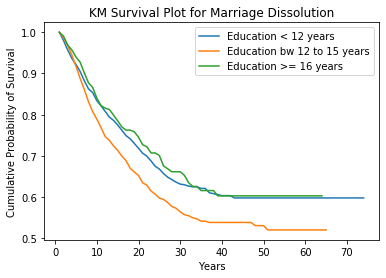

In [11]:
plt.plot(km_df_0['Year'], km_df_0['C_Prob'])
plt.plot(km_df_1['Year'], km_df_1['C_Prob'])
plt.plot(km_df_2['Year'], km_df_2['C_Prob'])
plt.xlabel("Years")
plt.ylabel("Cumulative Probability of Survival")
plt.title("KM Survival Plot for Marriage Dissolution")
plt.legend(['Education < 12 years', 'Education bw 12 to 15 years', 'Education >= 16 years'])
plt.show()

## Log-rank Test

For this test, only two groups ('Education bw 12 to 15 years' and 'Education >= 16 years') shall be considered.

In [12]:
def LogRankTest(df1, df2):
    cdf = pd.concat([df1, df2], axis=1)
    cdf = cdf.assign(TOT_RSKS = cdf.N_of_couples_1 + cdf.N_of_couples_2)
    cdf = cdf.assign(TOT_EVNTS = cdf.N_of_divorces_1 + cdf.N_of_divorces_2)
    cdf = cdf.assign(EXP_EVNTS_1 = cdf.N_of_couples_1*(cdf.TOT_EVNTS/cdf.TOT_RSKS))
    cdf = cdf.assign(EXP_EVNTS_2 = cdf.N_of_couples_2*(cdf.TOT_EVNTS/cdf.TOT_RSKS))
    return list(cdf.sum(axis=0, skipna=True))

In [13]:
df1_mod = km_df_1; df2_mod = km_df_2;
df1_mod.drop(['Year', '#_of_censored_couples', 'Prob_D', 'Comp_Prob_D', 'C_Prob'], axis=1, inplace=True)
df1_mod.columns = ['N_of_couples_1', 'N_of_divorces_1']
df2_mod.drop(['Year', '#_of_censored_couples', 'Prob_D', 'Comp_Prob_D', 'C_Prob'], axis=1, inplace=True)
df2_mod.columns = ['N_of_couples_2', 'N_of_divorces_2']

In [14]:
res_list = LogRankTest(df1_mod, df2_mod)
chi_sq = (((res_list[1] - res_list[6])**2)/res_list[6]) + (((res_list[3] - res_list[7])**2)/res_list[7])
print("Value of Chi-Square: " + str(chi_sq))
print("Since value of chi-square is greater than 3.84, null hypthesis is rejected. There is significant evidence that the two survival curves are different.")

Value of Chi-Square: 8.446842420406547
Since value of chi-square is greater than 3.84, null hypthesis is rejected. There is significant evidence that the two survival curves are different.


## Median Survival

From the above graph, median survival (survival probability of 50%) for the groups are: <br>

Education < 12 years = 25 years <br>
Education bw 12 and 15 years = 18 years <br>
Education >= 16 years = 30 years

# Question 2

## Imports

In [15]:
import numpy as np

## Generate Data

In [16]:
grp1 = np.random.exponential(5, 100).round()
grp2 = np.random.exponential(8, 100).round()

In [17]:
grp1_mod = [x if x != 0 else 1.0 for x in grp1]
grp1_mod = list(map(int, grp1_mod))
grp2_mod = [x if x != 0 else 1.0 for x in grp2]
grp2_mod = list(map(int, grp2_mod))

In [18]:
def censorData(data):
    max_val = max(data)
    df = pd.DataFrame(columns=['death_after', 'status'])    # death_after -> Death after no. of days, status -> 1 - record censored, 0 - not censored
    censor = np.random.choice([0, 1], 100, [0.9, 0.1])
    for d in range(100):
        df.loc[d] = [data[d], censor[d]]
    return df

In [19]:
df1 = censorData(grp1_mod)
df2 = censorData(grp2_mod)

## KM Plot

In [20]:
def calcRecord(df, i):
    c = 0; d = 0; cn = 0;
    for j, row in df.iterrows():
        if df.at[j, 'death_after'] > i:
            c += 1
        elif df.at[j, 'death_after'] == i:
            c += 1
            if df.at[j, 'status'] == 0:
                d += 1
            else:
                cn += 1
    return c, d, cn

In [21]:
def KMChart(df):
    max_val = df['death_after'].max()
    columns = ['day', 'current', 'deaths', 'censored', 'p', 'p_dash']
    km_df = pd.DataFrame(columns=columns)
    for y in range(max_val+1):
        c, d, cn = calcRecord(df, y)
        km_df.loc[y] = [y+1, c, d, cn, d/c, 1-(d/c)]
    # Calculate cumulative probability
    cum_P = calcCP(km_df['p_dash'])
    km_df['P'] = cum_P
    return km_df

In [22]:
km_df_1 = KMChart(df1)
km_df_2 = KMChart(df2)

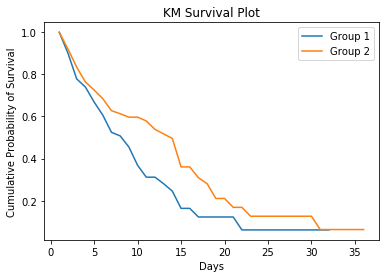

In [23]:
plt.plot(km_df_1['day'], km_df_1['P'])
plt.plot(km_df_2['day'], km_df_2['P'])
plt.xlabel("Days")
plt.ylabel("Cumulative Probability of Survival")
plt.title("KM Survival Plot")
plt.legend(['Group 1', 'Group 2'])
plt.show()

## Log-rank Test

In [24]:
def LogRankTest2(df1, df2):
    cdf = pd.concat([df1, df2], axis=1)
    cdf = cdf.assign(TOT_RSKS = cdf.current_1 + cdf.current_2)
    cdf = cdf.assign(TOT_EVNTS = cdf.deaths_1 + cdf.deaths_2)
    cdf = cdf.assign(EXP_EVNTS_1 = cdf.current_1*(cdf.TOT_EVNTS/cdf.TOT_RSKS))
    cdf = cdf.assign(EXP_EVNTS_2 = cdf.current_2*(cdf.TOT_EVNTS/cdf.TOT_RSKS))
    return list(cdf.sum(axis=0, skipna=True))

In [25]:
df1_mod = km_df_1; df2_mod = km_df_2;
df1_mod.drop(['day', 'censored', 'p', 'p_dash', 'P'], axis=1, inplace=True)
df1_mod.columns = ['current_1', 'deaths_1']
df2_mod.drop(['day', 'censored', 'p', 'p_dash', 'P'], axis=1, inplace=True)
df2_mod.columns = ['current_2', 'deaths_2']

In [27]:
res_list = LogRankTest2(df1_mod, df2_mod)
chi_sq = (((res_list[1] - res_list[6])**2)/res_list[6]) + (((res_list[3] - res_list[7])**2)/res_list[7])
print("Value of Chi-Square: " + str(chi_sq))
print("Since value of chi-square is greater than 3.84, null hypthesis is rejected. There is significant evidence that the two survival curves are different.")

Value of Chi-Square: 4.035041866257284
Since value of chi-square is greater than 3.84, null hypthesis is rejected. There is significant evidence that the two survival curves are different.


# References

1. Dataset - Lillard and Panis (2000), aML Multilevel Multiprocess Statistical Software, Release 1.0, EconWare, LA, California. <br>
2. Comparing Survival Curves - http://sphweb.bumc.bu.edu/otlt/MPH-Modules/BS/BS704_Survival/BS704_Survival5.html <br>
3. Survival Analysis Tutorial - https://www.youtube.com/watch?v=tiCyQp29nwA&list=WL&index=5&t=0s <br>